# COVID Testing and Health Equity 


In [126]:
import pandas as pd
import numpy as np
import requests

from io import StringIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

pd.options.display.float_format = "{:,.0f}".format
%matplotlib inline


## 1. Import and clean MTA turnstile data
Source: http://web.mta.info/developers/turnstile.html     <br/>
Backround: https://new.mta.info/agency/new-york-city-transit/subway-bus-ridership-2019
<br/>One week of data: http://web.mta.info/developers/data/nyct/turnstile/turnstile_190406.txt
<br/>
MTA Subway Hourly Ridership [Overview](https://data.ny.gov/api/views/wujg-7c2s/files/4c240b27-4ad8-4677-b102-fc93a0069d9d?download=true&filename=MTA_SubwayHourlyRidership_Overview.pdf)
and [Data Dictionary](https://data.ny.gov/api/views/wujg-7c2s/files/00d31e71-7194-468c-84df-76146b40663a?download=true&filename=MTA_SubwayHourlyRidership_DataDictionary.pdf)

In [116]:
url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190406.txt"

data = StringIO(requests.get(url).text)
df = pd.read_csv(data)
print(df.shape)

(202964, 11)


In [117]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781


#### URLs end with the date of each Saturday in format YYMMDD: April 6, 2019 is `.../turnstile_190406.txt`

## 2019 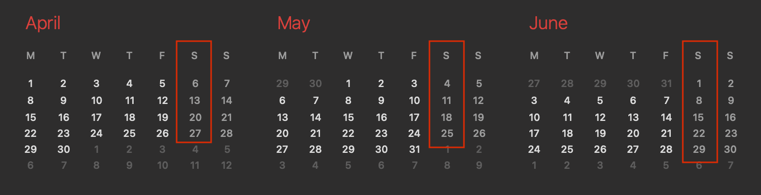

In [99]:
def get_data_parse_dt(weeks):
    '''
    Pass list of dates to retrieve weekly data from April, May, and June 2019. 
    Parse datetime from columns DATE and TIME.
    '''
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    
    weeks = [190406, 190413, 190420, 190427, 
             190504, 190511, 190518, 190525, 
             190601, 190608, 190615, 190622, 190629]
    
    for week in weeks:
        file_url = url.format(week)
        weekly_data.append(pd.read_csv(file_url,
                               parse_dates=[['DATE','TIME']], 
                               keep_date_col=True))
    return pd.concat(weekly_data)

In [181]:
df = get_data_parse_dt(weeks)
df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,2019-03-30 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,00:00:00,REGULAR,6999064,2373568
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576
2,2019-03-30 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,08:00:00,REGULAR,6999107,2373622
3,2019-03-30 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,12:00:00,REGULAR,6999214,2373710
4,2019-03-30 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,16:00:00,REGULAR,6999451,2373781


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202964 entries, 0 to 202963
Data columns (total 12 columns):
 #   Column                                                                Non-Null Count   Dtype         
---  ------                                                                --------------   -----         
 0   DATE_TIME                                                             202964 non-null  datetime64[ns]
 1   C/A                                                                   202964 non-null  object        
 2   UNIT                                                                  202964 non-null  object        
 3   SCP                                                                   202964 non-null  object        
 4   STATION                                                               202964 non-null  object        
 5   LINENAME                                                              202964 non-null  object        
 6   DIVISION                    

In [133]:
df.describe()

,ENTRIES,EXITS
count,"202,964","202,964"
mean,"40,717,599","33,266,058"
std,"210,354,362","193,462,329"
min,0,0
25%,"363,643","152,144"
50%,"2,215,918","1,292,625"
75%,"6,746,926","4,594,421"
max,"2,129,395,010","2,124,195,831"


In [188]:
df.nunique()

DATE_TIME                                                                13322
C/A                                                                        744
UNIT                                                                       467
SCP                                                                        220
STATION                                                                    377
LINENAME                                                                   114
DIVISION                                                                     6
DATE                                                                         7
TIME                                                                     12333
DESC                                                                         2
ENTRIES                                                                 169958
EXITS                                                                   168610
dtype: int64

In [137]:
# Strip whitespace from column names
df.columns = [column.strip() for column in df.columns]
df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [138]:
df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [189]:
df['STATION'].nunique()

377

# 🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖🔖

## 2. Select late night entry data

In [141]:
late_night_mask = df.copy()

In [142]:
# Mask selects the interval between 12:00 AM and 4:00 AM 
late_night_mask = (df['TIME'] == '04:00:00')
late_night_df = df[late_night_mask]
late_night_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,04:00:00,REGULAR,6999983,2373876


In [143]:
# Confirm df only has data from the 4:00 AM interval
late_night_df.TIME.unique()

array(['04:00:00'], dtype=object)

## 3. Calculate late night entries

In [144]:
late_night_entries_df = late_night_df.copy()
late_night_entries_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,04:00:00,REGULAR,6999983,2373876


In [145]:
# What type of data are in the DESC column? REGULAR and RECOVR AUD
# How many of the entries are RECOVR AUD? Can we filter them out? Yes, small percentage. 

late_night_entries_df.DESC.value_counts()

REGULAR       17253
RECOVR AUD       51
Name: DESC, dtype: int64

In [146]:
# Mask selects the REGULAR entries in the DESC column

desc_mask = (late_night_entries_df['DESC'] == 'REGULAR')
late_night_entries_df = (late_night_entries_df[desc_mask])

In [147]:
# Confirm that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique

(late_night_entries_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-03-30 04:00:00,1
11508,R148,R033,01-03-03,TIMES SQ-42 ST,2019-04-04 04:00:00,1
11494,R148,R033,01-03-01,TIMES SQ-42 ST,2019-04-04 04:00:00,1
11495,R148,R033,01-03-01,TIMES SQ-42 ST,2019-04-05 04:00:00,1
11496,R148,R033,01-03-02,TIMES SQ-42 ST,2019-03-30 04:00:00,1


In [148]:
# Create new columns for the previous date and entries. 
# Apply a shift to calculate the previous day's entries. 

v = (late_night_entries_df[["DATE", "ENTRIES"]].apply(lambda grp: grp.shift(1)))
late_night_entries_df['PREV_DATE'] = v['DATE']
late_night_entries_df['PREV_ENTRIES'] = v['ENTRIES']

late_night_entries_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576,NaN,NaN
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,04:00:00,REGULAR,6999983,2373876,03/30/2019,"6,999,084"


In [149]:
# How many stations have a counter going in reverse? 

(late_night_entries_df[late_night_entries_df['ENTRIES'] < late_night_entries_df["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())


C/A    UNIT  SCP       STATION   
A002   R051  02-00-01  59 ST         1
             02-03-00  59 ST         1
             02-03-01  59 ST         1
             02-03-03  59 ST         1
             02-03-06  59 ST         1
                                    ..
S101A  R070  01-03-01  ST. GEORGE    1
             01-03-02  ST. GEORGE    1
             01-03-03  ST. GEORGE    1
             01-05-00  ST. GEORGE    1
             01-05-01  ST. GEORGE    1
Length: 1273, dtype: int64

In [150]:
# Adjust counter 

def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter


In [151]:
late_night_entries_df["LATE_NIGHT_ENTRIES"] = late_night_entries_df.apply(get_daily_counts, 
                                                                          axis=1, 
                                                                          max_counter=1000000)


1211485 6244921.0
6132837 1055829.0
7068485 5700185.0
11343688 7075278.0
8906748 11354247.0
112 8914543.0
4218583 144210.0
15053780 4238350.0
10972322 15067670.0
3430241 10982316.0
1448019 4269945.0
18655173 1459100.0
1706203 18671324.0
109780 1733224.0
2871665 255756.0
6020763 2901302.0
4782692 6022550.0
6064948 4786341.0
986 5784970.0
2994632 42245.0
6884639 3002297.0
1566408 6889738.0
12418301 34891.0
563844 12429375.0
3785735 573065.0
8680613 3794272.0
7121077 8687862.0
6018159 7127752.0
3686540 6023830.0
5469727 3694554.0
14649812 5478863.0
1305964 14663697.0
4051 1306861.0
8693471 4542.0
3294668 8711303.0
2302253 3307712.0
2873805 1843764.0
26712190 2886674.0
14593211 26758830.0
67617692 14617215.0
5218189 67620412.0
12525174 4476841.0
13665116 12547547.0
7710346 13685897.0
1238569560 7158178.0
689735 1238548874.0
10809812 715085.0
14712311 10821823.0
84988855 14725157.0
3404515 84993336.0
39561 3412558.0
2016323 48807.0
4172905 2717995.0
6343752 4175962.0
7523065 6349723.0
44427

5031308 40483.0
50777 5032926.0
2909056 1.0
6881850 2911672.0
2861004 6888230.0
13192242 2872159.0
12118816 13204238.0
13600440 12128134.0
2316734 13610957.0
123344 2323414.0
8196460 128661.0
4036197 8201945.0
5287547 4042530.0
1065 5291531.0
2484506 5.0
10070702 2109477.0
12792 10076150.0
4474345 17752.0
8324185 4488095.0
1709831 8338673.0
4813760 1733715.0
8983739 4822086.0
6236070 8993425.0
874705 6242585.0
7490774 880635.0
949326 7498221.0
2086443 456949.0
433291 2089478.0
1668748 352166.0
3058818 1670049.0
1803080 3065081.0
5531035 1811322.0
1258613 5536131.0
1041721 2289838.0
4813996 115271.0
3662111 4819043.0
1322970 3666797.0
2455882 1324553.0
5127954 2462053.0
3041449 4157842.0
4897152 3048281.0
2860175 4899693.0
11285597 2865531.0
8626926 11292459.0
890438 8637239.0
2933876 902796.0
4228875 2947670.0
181013 4242807.0
67607015 23294.0
23348 67609733.0
4962983 25260.0
797898 4969155.0
2286695 807255.0
460312 2292342.0
2315144 748329.0
967543 2315976.0
63845 1599137.0
1792275 53

In [152]:
late_night_entries_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,LATE_NIGHT_ENTRIES
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/30/2019,04:00:00,REGULAR,6999084,2373576,NaN,NaN,NaN
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,04:00:00,REGULAR,6999983,2373876,03/30/2019,"6,999,084",899


In [153]:
# Drop row with the March 31, 2019 data, used it to calculate the previous entries, no longer neeeded. 

late_night_entries_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
late_night_entries_df.head(2)


,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,LATE_NIGHT_ENTRIES
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/31/2019,04:00:00,REGULAR,6999983,2373876,03/30/2019,"6,999,084",899
13,2019-04-01 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/01/2019,04:00:00,REGULAR,7000539,2374095,03/31/2019,"6,999,983",556


In [154]:
# Add up all turnstiles by station and reset index 

late_night_entries_df = (late_night_entries_df.groupby(['STATION', 'DATE_TIME', 'LINENAME'])
                         [['LATE_NIGHT_ENTRIES']]
                         .sum()).reset_index()
late_night_entries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702 entries, 0 to 1701
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   STATION             1702 non-null   object        
 1   DATE_TIME           1702 non-null   datetime64[ns]
 2   LINENAME            1702 non-null   object        
 3   LATE_NIGHT_ENTRIES  1702 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 53.3+ KB


In [155]:
# Add column DAY_OF_WEEK to display day of week (Monday = 0, Sunday = 6)

late_night_entries_df['DAY_OF_WEEK'] = pd.to_datetime(late_night_entries_df['DATE_TIME']).dt.dayofweek
late_night_entries_df.head(2)


,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,L,"1,618,348",5
1,1 AV,2019-03-31 04:00:00,L,"15,402",6


## 4. Calculate rolling mean of late night entries

In [156]:
rolling_mean_df = late_night_entries_df.copy()
rolling_mean_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,L,"1,618,348",5
1,1 AV,2019-03-31 04:00:00,L,"15,402",6


In [157]:
# Add column ROLLING_MEAN to capture the weekly rolling mean for each station 

rolling_mean_df['ROLLING_MEAN'] = (rolling_mean_df
                        .groupby('STATION')['LATE_NIGHT_ENTRIES']
                        .transform(lambda x: x.rolling(7,1).mean()))
rolling_mean_df[['STATION','DATE_TIME','LATE_NIGHT_ENTRIES','ROLLING_MEAN','DAY_OF_WEEK']].head(2) 
# rolling_mean_df

,STATION,DATE_TIME,LATE_NIGHT_ENTRIES,ROLLING_MEAN,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,"1,618,348","1,618,348",5
1,1 AV,2019-03-31 04:00:00,"15,402","816,875",6


In [158]:
# Mask selects the last day of each station's rolling mean; Sunday=6

last_rolling_day_mask = (rolling_mean_df['DAY_OF_WEEK'] == 6)
rolling_mean_df = rolling_mean_df[last_rolling_day_mask]
rolling_mean_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
1,1 AV,2019-03-31 04:00:00,L,"15,402",6,"816,875"
8,103 ST-CORONA,2019-03-31 04:00:00,7,"13,474",6,"292,094"


In [159]:
# Comfirm df only has Sunday

rolling_mean_df.DAY_OF_WEEK.unique()


array([6])

In [160]:
# How many stations? 213; started with 378 
# Some stations were ommited during clean up. 
# Perhaps some stations don't have late night service or were closed for repair. 

len(rolling_mean_df.STATION.unique())


211

In [161]:
# Sort by ROLLING_MEAN and reset index 

rolling_mean_df = rolling_mean_df.sort_values('ROLLING_MEAN', ascending=False).reset_index(drop=True)
rolling_mean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   STATION             244 non-null    object        
 1   DATE_TIME           244 non-null    datetime64[ns]
 2   LINENAME            244 non-null    object        
 3   LATE_NIGHT_ENTRIES  244 non-null    float64       
 4   DAY_OF_WEEK         244 non-null    int64         
 5   ROLLING_MEAN        244 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 11.6+ KB


In [162]:
rolling_mean_group = (rolling_mean_df
                      .groupby('STATION')[['ROLLING_MEAN']].mean())

In [163]:
rolling_mean_group.reset_index(inplace=True)

In [164]:
# Select top stations with the highest rolling mean on Sunday

rolling_mean_group.sort_values('ROLLING_MEAN', ascending=False)
rolling_mean_group_top = rolling_mean_group.loc[:9]
rolling_mean_group_top

,STATION,ROLLING_MEAN
0,1 AV,"816,875"
1,103 ST-CORONA,"292,094"
2,104 ST,"399,235"
3,110 ST,"396,441"
4,111 ST,"4,253"
5,121 ST,"1,276,261"
6,125 ST,"307,721"
7,135 ST,"685,754"
8,138/GRAND CONC,"304,194"
9,14 ST,"2,075,003"


## 5. Plot top stations by highest late night rolling mean

### Which stations outside of Manhattan have high late night entries? 

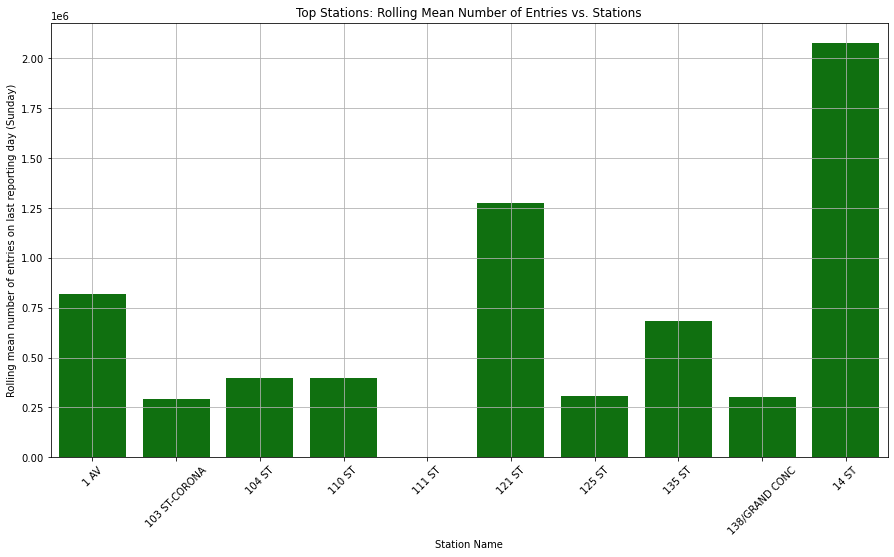

In [187]:
# Plot top stations: Rolling mean number of entres vs stations

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'STATION', y = 'ROLLING_MEAN', data = rolling_mean_group_top, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set(title='Top Stations: Rolling Mean Number of Entries vs. Stations')
ax.set(xlabel=('Station Name'))
ax.set(ylabel=('Rolling mean number of entries on last reporting day (Sunday)'))
plt.grid();


One station outside of Manhattan is both in Queens and on the 7 train. 
Let's look at the stations along the 7 line in Queens. 

## 6. Plot 7 train stations in Queens 

In [166]:
seven_line_df = rolling_mean_df.copy() # Using df with rolling mean
seven_line_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
0,34 ST-PENN STA,2019-03-31 04:00:00,123,"17,001",6,"6,198,087"
1,34 ST-HERALD SQ,2019-03-31 04:00:00,BDFMNQRW,"78,790",6,"5,511,591"


In [167]:
# Looking for linename of interest: 7 line 

seven_line_df = seven_line_df[seven_line_df['LINENAME'].str.contains('7', na=False)] 
seven_line_df.head(10)

# The 7 train shares stations with other train lines. Will omit multi-train stations in this analysis. 
# Line name as recorded in dataset: 7


,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
5,42 ST-PORT AUTH,2019-03-31 04:00:00,ACENQRS1237W,"36,598",6,"3,474,060"
11,GRD CNTRL-42 ST,2019-03-31 04:00:00,4567S,"38,103",6,"2,829,847"
13,34 ST-HUDSON YD,2019-03-31 04:00:00,7,"19,111",6,"2,674,048"
16,42 ST-BRYANT PK,2019-03-31 04:00:00,BDFM7,"15,676",6,"2,400,286"
27,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"2,000,721"
36,5 AVE,2019-03-31 04:00:00,7BDFM,"5,583",6,"1,651,434"
40,TIMES SQ-42 ST,2019-03-31 04:00:00,1237ACENQRS,"17,042",6,"1,538,861"
52,COURT SQ,2019-03-31 04:00:00,7,"4,172",6,"1,312,422"
63,TIMES SQ-42 ST,2019-03-31 04:00:00,1237ACENQRSW,"45,572",6,"1,240,203"
66,VERNON-JACKSON,2019-03-31 04:00:00,7,"10,591",6,"1,208,780"


In [168]:
# Mask selects the 7 train only stations

seven_mask = (seven_line_df['LINENAME'] == '7')
seven_line_df = seven_line_df[seven_mask]
seven_line_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
13,34 ST-HUDSON YD,2019-03-31 04:00:00,7,"19,111",6,"2,674,048"
27,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"2,000,721"


In [169]:
# Comfirm df has only 7 line data

seven_line_df.LINENAME.unique()

array(['7'], dtype=object)

In [170]:
# How many 7 train stations in this dataset? 12

len(seven_line_df.STATION.unique())

12

In [171]:
# How many stations in Queens? All but one, 34 ST-HUDSON YD.   

seven_line_df.STATION.unique()

array(['34 ST-HUDSON YD', 'FLUSHING-MAIN', 'COURT SQ', 'VERNON-JACKSON',
       '46 ST BLISS ST', '90 ST-ELMHURST', '40 ST LOWERY ST',
       '82 ST-JACKSON H', '33 ST-RAWSON ST', '103 ST-CORONA',
       'JUNCTION BLVD', '111 ST'], dtype=object)

In [172]:
# Mask selects only the Queens stations

queens_mask = (seven_line_df['STATION'] != '34 ST-HUDSON YD')
seven_line_df = seven_line_df[queens_mask]
seven_line_df.head(5)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
27,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"2,000,721"
52,COURT SQ,2019-03-31 04:00:00,7,"4,172",6,"1,312,422"
66,VERNON-JACKSON,2019-03-31 04:00:00,7,"10,591",6,"1,208,780"
71,46 ST BLISS ST,2019-03-31 04:00:00,7,"8,797",6,"1,158,996"
105,90 ST-ELMHURST,2019-03-31 04:00:00,7,"11,087",6,"830,892"


### Which 7 train stations in Queens have high late night entries? 

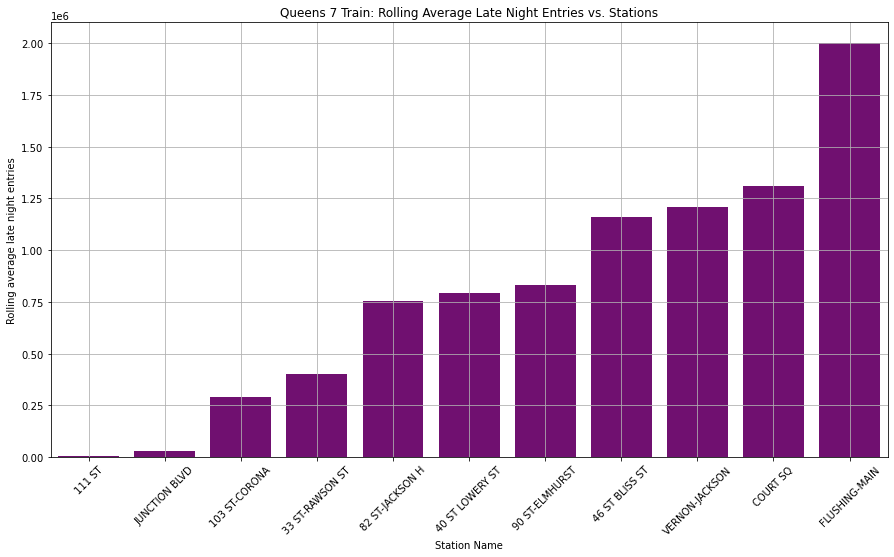

In [185]:
# Plot 7 line in Queens: Rolling average late night entries vs Queens 7 train stations

plt.figure(figsize = (15,8))
ax = sns.barplot(x='STATION', y='ROLLING_MEAN', data=seven_line_df.sort_values('ROLLING_MEAN'), color='purple')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set(title='Queens 7 Train: Rolling Average Late Night Entries vs. Stations')
ax.set(xlabel=('Station Name'))
ax.set(ylabel=('Rolling average late night entries'))
plt.grid();


The range of people entering a station on the 7 train during late-night hours varies. 
One station has high late night entries.<br/>
What days are the busiest at Flushing Station? 



## 7. Plot average late night entries at Flushing Station by day of week

In [174]:
flushing_df = late_night_entries_df.copy() # Using df without rolling mean

In [175]:
# Mask selects FLUSHING-MAIN

flushing_mask = (flushing_df['STATION'] == 'FLUSHING-MAIN')
flushing_df = flushing_df[flushing_mask]


In [176]:
# Confirm df only has Flushing data

flushing_df.STATION.unique()


array(['FLUSHING-MAIN'], dtype=object)

In [177]:
flushing_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
1100,FLUSHING-MAIN,2019-03-30 04:00:00,7,"4,001,438",5
1101,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6


In [178]:
# Calculate Flushing WEEK_DAY_MEAN

flushing_df['WEEK_DAY_MEAN'] = (flushing_df
                                .groupby('DAY_OF_WEEK')['LATE_NIGHT_ENTRIES']
                                .transform(lambda x: x.mean()))
flushing_df.head(10)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,WEEK_DAY_MEAN
1100,FLUSHING-MAIN,2019-03-30 04:00:00,7,"4,001,438",5,"4,001,438"
1101,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,4
1102,FLUSHING-MAIN,2019-04-01 04:00:00,7,37,0,37
1103,FLUSHING-MAIN,2019-04-02 04:00:00,7,"57,655",1,"57,655"
1104,FLUSHING-MAIN,2019-04-03 04:00:00,7,"59,024",2,"59,024"
1105,FLUSHING-MAIN,2019-04-04 04:00:00,7,"59,802",3,"59,802"
1106,FLUSHING-MAIN,2019-04-05 04:00:00,7,"60,840",4,"60,840"


In [179]:
# Mask selects every day but Saturday=5. 
# Saturdays may record people going out late to bars or nightclubs

saturday_mask = (flushing_df['DAY_OF_WEEK'] != 5)
flushing_df = flushing_df[saturday_mask]
flushing_df.head(5)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,WEEK_DAY_MEAN
1101,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,4
1102,FLUSHING-MAIN,2019-04-01 04:00:00,7,37,0,37
1103,FLUSHING-MAIN,2019-04-02 04:00:00,7,"57,655",1,"57,655"
1104,FLUSHING-MAIN,2019-04-03 04:00:00,7,"59,024",2,"59,024"
1105,FLUSHING-MAIN,2019-04-04 04:00:00,7,"59,802",3,"59,802"


### What days are the busiest at Flushing Station?

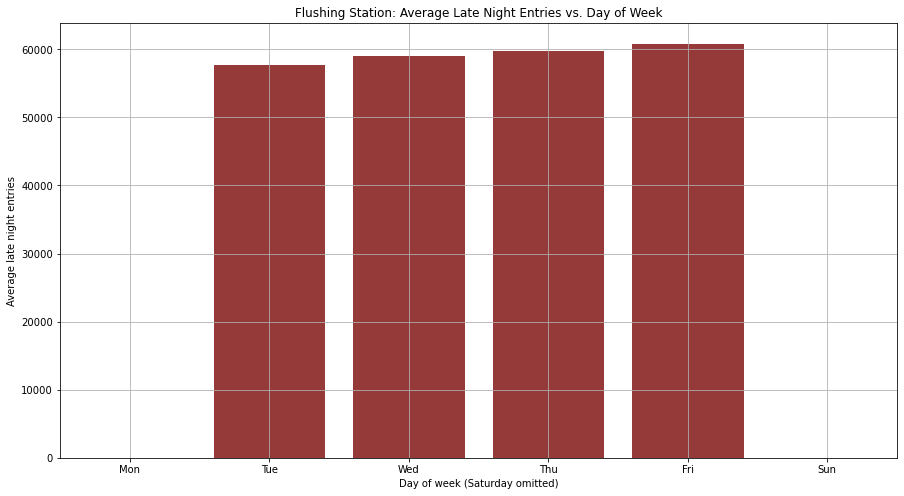

In [184]:
# Plot Flushing average week: Average late night entries vs day of week

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'DAY_OF_WEEK', y = 'WEEK_DAY_MEAN', data = flushing_df, color='brown')
ax.set(title='Flushing Station: Average Late Night Entries vs. Day of Week')
ax.set(xlabel=('Day of week (Saturday omitted)'))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sun'])
ax.set(ylabel=('Average late night entries'))
plt.grid();


Tuesday through Friday have the highest late night entries at the Flushing station.